In [13]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm 

### Načtení dat
Funkce načte obrazy a metadata z definovaných cest a vrátila by je jako Numpy pole. Pak bychom mohli tyto data použít při trénování modelu GAN, přičemž bychom mohli model upravit tak, aby byl podmíněný, což znamená, že by generoval obrazy na základě zadání metadat (např. generování obrazu žilního řečiště pro muže ve věku 25 let, který je kuřákem).

In [14]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from pathlib import Path

def load_data(metadata_path, data_directory, num_folders=1):
    metadata = pd.read_excel(metadata_path)
    
    images = []
    labels = []
    
    # Count total images in the dataset directory
    total_images = sum(1 for _ in Path(data_directory).rglob('*.png'))
    
    finger_folders = ["l_index", "l_little", "l_middle", "l_ring", "l_thumb", 
                      "r_index", "r_little", "r_middle", "r_ring", "r_thumb"]
    
    progress_bar = tqdm(total=total_images, desc='Loading images', dynamic_ncols=True)
    
    for index, row in metadata.iterrows():
        if index >= num_folders:
            break
            
        for finger_folder in finger_folders:
            folder_path = Path(data_directory) / str(row['id']) / finger_folder
            
            if folder_path.exists():
                image_files = list(folder_path.glob("*.png"))
                
                for img_path in image_files:
                    img = Image.open(img_path)
                    img = np.array(img)
                    
                    images.append(img)
                    
                    label = {
                        'id': row['id'],
                        'gender': row['gender'],
                        'age': row['age'],
                        'melanin': row['melanin'],
                        'cardiovascular_disease': row['cardiovascular disease'],
                        'smoker': row['smoker'],
                        'sport_hobby_with_fingers': row['sport/hobby with fingers'],
                        'alcohol_before_scan': row['alcohol before scan'],
                        'skin_disease': row['skin disease'],
                        'finger': finger_folder
                    }
                    labels.append(label)
                    progress_bar.update(1)
                
    progress_bar.close()
    return np.array(images), labels

# You can call this function to load the data:
images, labels = load_data("data_description.xlsx", "dataset")



Loading images:   0%|          | 0/1458 [00:00<?, ?it/s]

### Images preprocessing

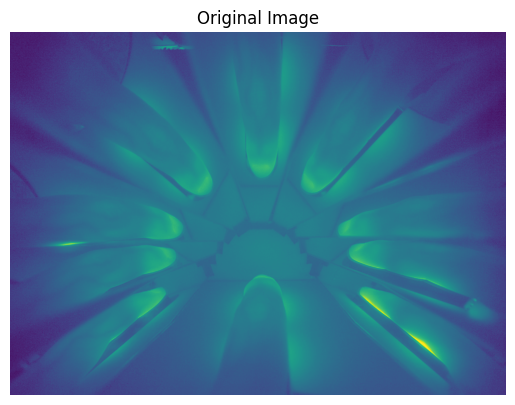

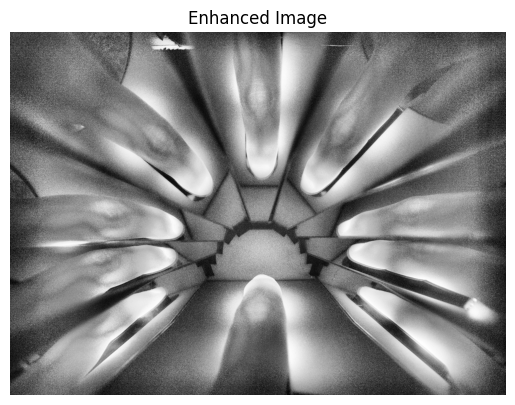

In [58]:
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, filters, util
from skimage.color import rgb2gray
from skimage import io, color
from PIL import Image

# Function to preprocess a single image
def preprocess_image(image, target_size=(128, 128)):
    # Convert image to numpy array if not already
    img_array = np.array(image)

    # Check if the image has an alpha channel (transparency)
    if img_array.shape[-1] == 4:
        # Convert to RGB first, then grayscale
        grayscale_img = color.rgb2gray(img_array[..., :3])
    elif img_array.shape[-1] == 3:
        # Convert to grayscale
        grayscale_img = color.rgb2gray(img_array)
    else:
        # Image is already grayscale
        grayscale_img = img_array

    # Apply histogram equalization
    equalized_img = exposure.equalize_adapthist(grayscale_img, clip_limit=0.03)
    print(equalized_img)
    #print its size 
    print(equalized_img.shape)
    # Convert the numpy array back to a PIL Image in grayscale mode
    processed_image = Image.fromarray((equalized_img * 255).astype(np.uint8), mode='L')

    processed_image = processed_image.resize(target_size, Image.ANTIALIAS)

    return processed_image

# Display the original image
plt.imshow(images[0])
plt.axis('off')
plt.title('Original Image')
plt.show()

processed_image = preprocess_image(images[0])
# Display the preprocessed first image
plt.imshow(processed_image, cmap='gray')
plt.axis('off')
plt.title('Enhanced Image')
plt.show()


In [ ]:
# We need to resize the image while maintaining the aspect ratio to 256x256 for GAN input.
# Let's first define a function to resize the image with aspect ratio maintained.

def resize_image_aspect_ratio(image, target_size):
    # Calculate the target height and width with aspect ratio maintained
    original_height, original_width = image.shape[:2]
    ratio = min(target_size[0] / original_height, target_size[1] / original_width)
    new_size = (int(original_width * ratio), int(original_height * ratio))

    # Resize the image with the new size
    image_resized = util.img_as_ubyte(transform.resize(image, new_size, anti_aliasing=True))

    # Now we need to pad the resized image to make it exactly target_size
    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    padding = ((delta_h // 2, delta_h - (delta_h // 2)), (delta_w // 2, delta_w - (delta_w // 2)), (0, 0))
    image_padded = np.pad(image_resized, padding, mode='constant', constant_values=0)

    return image_padded

# Now let's load the preprocessed image and resize it
preprocessed_image_path = '/mnt/data/preprocessed_image.png'
preprocessed_image = io.imread(preprocessed_image_path)

# Target size for GAN
target_gan_size = (256, 256)

# Resize and pad the image
gan_ready_image = resize_image_aspect_ratio(preprocessed_image, target_gan_size)

# Convert the numpy array back to a PIL Image for compatibility with GANs
gan_ready_image_pil = Image.fromarray(gan_ready_image)

# Display the GAN ready image
plt.imshow(gan_ready_image_pil, cmap='gray')
plt.axis('off')  # Hide axis
plt.title('GAN Ready Image')
plt.show()

# Save the PIL image if needed for GAN input
output_gan_path = '/mnt/data/gan_ready_image.png'
gan_ready_image_pil.save(output_gan_path)
output_gan_path


### Model Implementation and Training

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator
class Generator():
    def build_generator(z_dim, condition_shape, img_shape):
    # Noise input
    z_input = layers.Input(shape=(z_dim,))
    # Conditional input
    condition_input = layers.Input(shape=(condition_shape,))
    
    # Combine noise and condition
    x = layers.Concatenate()([z_input, condition_input])
    
    # Start with a fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Up-sample to the correct image size
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(np.prod(img_shape), activation='tanh')(x)
    img = layers.Reshape(img_shape)(x)
    
    # Create the model
    generator = models.Model([z_input, condition_input], img, name='generator')
    return generator

# Discriminator
class Discriminator():
    pass
    # Add your discriminator architecture here

# Training function
def train_model(generator, discriminator):
    pass
    # Add your training loop here


IndentationError: expected an indented block after function definition on line 10 (473922504.py, line 12)

### Synthetic Image Generation

In [ ]:
def generate_images(generator, num_images):
    # code to generate synthetic images
    pass

### Result Verification

In [ ]:
def verify_results(synthetic_images):
    # Add your verification code here
    pass